# [06] Log Loss SGD Training (Concat, calfication)
This was our first attempt at using a different classifier than from MP3 and we used Scikit's Log Loss SGD model. We used our concatenated images and this time tried to classify between calcification or no calcification. Results were better than previous attempts but still not great.

Here we follow the tutorial from:

https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

Code used from the tutorial is marked as such

In [1]:
## Importing Libraries
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import os
import math as m
import time

In [2]:
## loading in important variables

# Eigenvectors
with open('train_concat_vectors.npy', 'rb') as f:
    train_concat_vectors = pickle.load(f) 
vectors = train_concat_vectors

# Keys
with open('OFFICIAL_keys.pkl', 'rb') as f:
    keys = pickle.load(f)
train_set = keys[:int(0.8*len(keys))]
test_set = keys[int(0.8*len(keys)):int(0.9*len(keys))+1]
validation_set = keys[int(0.9*len(keys))+1:]

# Images
with open('concat_imgs.npy', 'rb') as f:
    concat_imgs = pickle.load(f) 
scale = (162, 135)

# Classifications
with open('classifications.pkl', 'rb') as f:
    classifications = pickle.load(f)
classes = []
for i in range(2575):
    if classifications[2*i] != classifications[2*i+1]:
        print("Classification not equal")
    classes.append(classifications[2*i])
classes = np.array(classes)

# Abnormalities
with open('abnormalities.pkl', 'rb') as f:
    abnormalities = pickle.load(f)
abnorms = []
for i in range(2575):
    if abnormalities[2*i] != abnormalities[2*i+1]:
        print("abnormalities not equal")
    abnorms.append(abnormalities[2*i])
abnorms = np.array(abnorms)

Wall time: 1min 44s


In [4]:
## Takes flattened images (wxh, n), eigenvectors for the set, and k = new dimensionality
## Returns an array similar to flattened images array but with k instead of n dimensions
def reduce_dimensionality(imgs, vecs, k):
    reduced_dim = np.matmul(vecs[:k], imgs)
    return reduced_dim

## Converts the reduced dimension scan back to original image dimension
def reduced_to_img(reduced, vecs):
    approx = np.matmul(vecs[:reduced.shape[0]].T, reduced)
    return approx

## Combined the above two functions for convenience in creating downscaled images
def reduce_img_dim(imgs, vecs, k):
    return reduced_to_img(reduce_dimensionality(imgs, vecs, k), vecs)

In [23]:
## Set inputs (eigenvectors up to 2500) and labels (no calcification (0) or calcification (1))
dims = 2500
inputs = reduce_dimensionality(concat_imgs.T, vectors, dims).T
labels = []
for i in range(abnorms.shape[0]):
    if abnorms[i] == "calcification"  or abnorms[i] == "both":
        labels.append(1)
    else:
        labels.append(0)
labels = np.array(labels)

In [6]:
## Function to calculate class weights, actually used with this model as it can use weighting
def calculate_weights(labels):
    zero = np.count_nonzero(labels==0)
    ones = np.count_nonzero(labels==1)
    zero_freq = zero/labels.shape[0]
    ones_freq = ones/labels.shape[0]
    print(f"zero_freq={zero_freq}, ones_freq={ones_freq}")
    zero_weight = 0.5/zero_freq
    ones_weight = 0.5/ones_freq
    print(f"zero_weight={zero_weight}, ones_weight={ones_weight}")
    weights = []
    for i in range(labels.shape[0]):
        if labels[i] == 1:
            weights.append(ones_weight)
        else:
            weights.append(zero_weight)
    weights = np.array(weights)
    return weights
weights = calculate_weights(labels)
print(weights.shape)

zero_freq=0.7219417475728155, ones_freq=0.27805825242718446
zero_weight=0.6925766541151157, ones_weight=1.7981843575418994
(2575,)


In [ ]:
## Below from https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

The f1 score for the testing data: 0.296875


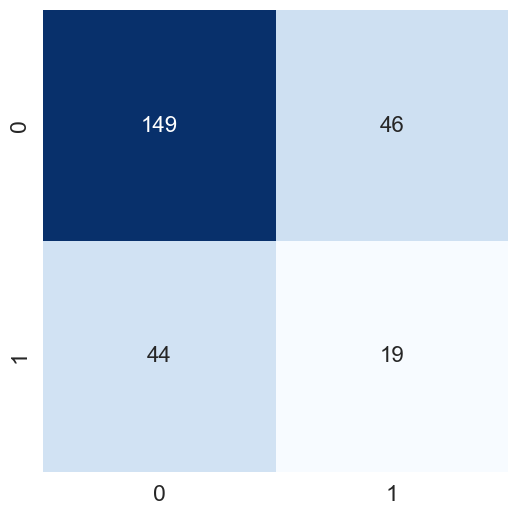

In [16]:
### TUTORIAL CODE ###
#importing and training the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Training the model unweighted
lr = LogisticRegression(solver='newton-cg')
lr.fit(inputs[train_set], labels[train_set])

# Predicting on the test data
pred_test = lr.predict(inputs[test_set])

# Calculating and printing the f1 score 
f1_test = f1_score(labels[test_set], pred_test)
print('The f1 score for the testing data:', f1_test)

# Function to create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
#Calling function 
conf_matrix(labels[test_set], pred_test)

The f1 score for the testing data: 0.33557046979865773


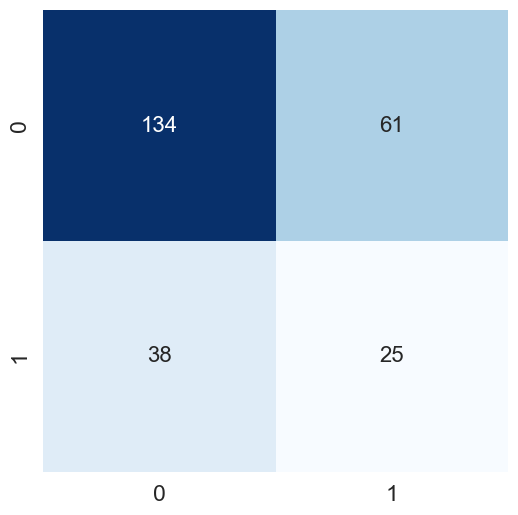

In [17]:
### TUTORIAL CODE ###
## Training the model now with 'balanced' class weights

lr = LogisticRegression(solver='newton-cg', class_weight='balanced')
lr.fit(inputs[train_set], labels[train_set])

# Predicting on the test data
pred_test = lr.predict(inputs[test_set])

#Calculating and printing the f1 score 
f1_test = f1_score(labels[test_set], pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(labels[test_set], pred_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Scoring for different class weights')

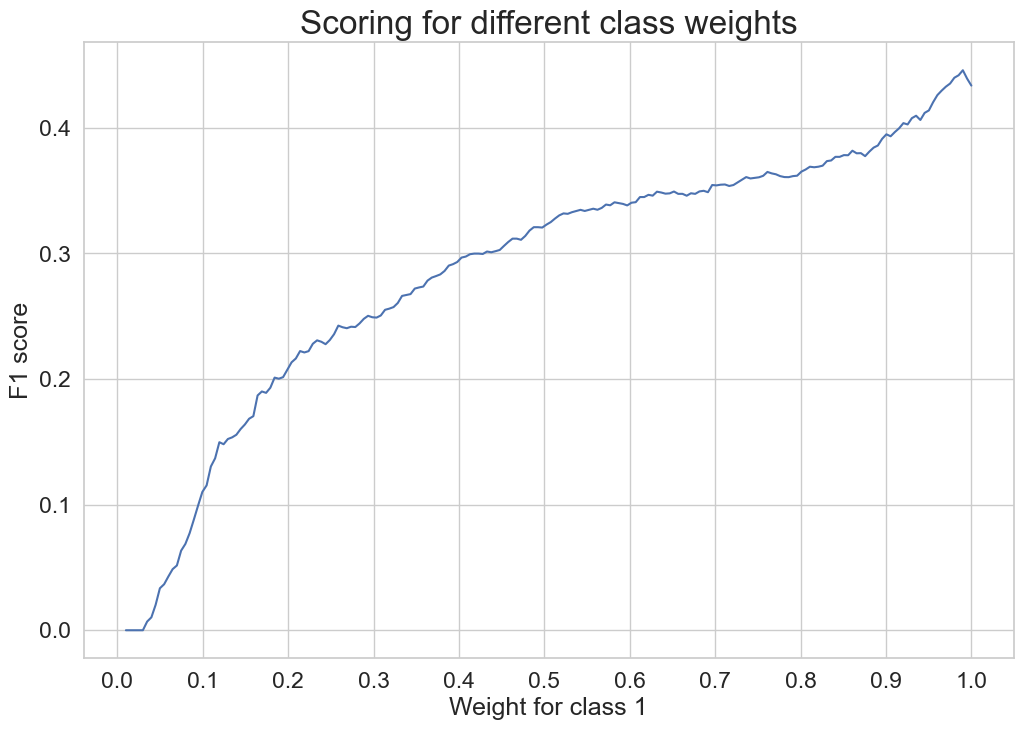

In [18]:
### TUTORIAL CODE ###
## Now Testing f1 score over a range of different class weights (note f1 score = TP / [TP - (1/2)(FP + FN)])
from sklearn.model_selection import GridSearchCV, StratifiedKFold
lr = LogisticRegression(solver='newton-cg')

#Setting the range for class weights
weights = np.linspace(0.0,0.99,200)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= lr, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(inputs[train_set], labels[train_set])

#Ploting the score for different values of weight
sns.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)

The f1 score for the testing data: 0.3896103896103896


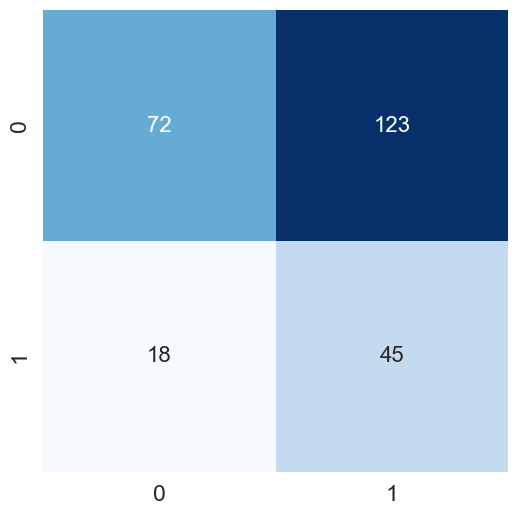

In [24]:
### TUTORIAL CODE ###
## Now training the model using our class weights for the highest f1 score
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='newton-cg', class_weight={0: 0.05, 1: 0.95})
lr.fit(inputs[train_set], labels[train_set])

# Predicting on the test data
pred_test = lr.predict(inputs[test_set])

#Calculating and printing the f1 score 
f1_test = f1_score(labels[test_set], pred_test)
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(labels[test_set], pred_test)